In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
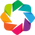

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# do t-test
from scipy.stats import ttest_ind

from SSMuLA.alde_analysis import avg_alde_df
from SSMuLA.fitness_process_vis import parse_lib_stat
from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.alde_analysis import avg_alde_df
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.vis_summary import (
    ZS_OPTS_APPENDED,
    ZS_COLOR_MAP_APPENDED
)

%matplotlib inline

In [4]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
TOTAL_N_LIST = [n + 96 for n in N_SAMPLE_LIST]

In [5]:
five_zs = {
    "none": PRESENTATION_PALETTE_SATURATE["gray"],
    "ed_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["orange"],
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
    "coves_score": PRESENTATION_PALETTE_SATURATE["brown"],
}

triad_colors = {
    "Triad-esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "Triad-ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "struc-comb_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}


In [6]:
lib_stat = parse_lib_stat(
    lib_csv_path="results/fitness_distribution/max/all_lib_stats.csv", n_mut_cuttoff=0
)
lib_stat

,lib,n_mut_cuttoff,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,...,scale,peaks,peak_kde,percentiles,pdf_values,parent_rank_percent,Q1,Q2,Q3,numb_kde_peak
0,DHFR,0,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,...,1.737006e-03,"[0.1275662158236592, 0.5084256342965795, 0.606...","[18.95715826406059, 0.17704519880582167, 0.098...","[0.1151661417338432, 0.1212571134074551, 0.122...","[15.199742695395578, 15.667091596432273, 16.11...",0.075250,0.125979,0.127567,0.129802,7
3,ParD2,0,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,...,1.099060e-01,"[0.03337870027347259, 0.6106664209434821, 0.85...","[2.870133679609529, 0.40012326949250876, 0.421...","[-0.2192609576095971, -0.11180451121954202, -0...","[0.026974121384613872, 0.028121215058096317, 0...",0.001522,0.023743,0.112118,0.374642,3
6,ParD3,0,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,...,1.567318e-01,"[0.12255350949782506, 0.2818697911295817, 0.89...","[1.5849621685610578, 1.5168268815479706, 0.556...","[-0.2057345859857947, -0.0879267691331092, -0....","[0.01869666257662742, 0.01949003646085834, 0.0...",0.000888,0.112217,0.276349,0.470212,3
9,GB1,0,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,...,2.786774e-04,"[0.001001001001001001, 0.15015015015015015, 0....","[84.94812751924495, 0.14711297529110418, 0.091...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[84.45520645025827, 84.94812751924495, 80.8935...",0.024397,0.000156,0.000386,0.001026,33
12,T7,0,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,...,3.213795e-20,"[0.12212212212212212, 0.22022022022022023, 0.2...","[0.1355385385042058, 0.10759849737430795, 0.09...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[25.89058161801743, 25.83678275907177, 25.6612...",0.024238,0.000000,0.000000,0.000000,11
15,TEV,0,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,...,1.890048e-02,"[-0.7917824701915064, -0.7605090595208127, -0....","[0.0036245994071766735, 0.0021495792852726805,...","[-0.8377727800013499, -0.26246975122161975, -0...","[0.13783458085674552, 0.1361875808265587, 0.12...",0.004179,-0.030314,-0.011234,0.008629,27
18,TrpB3A,0,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,...,2.442504e-02,"[-0.3944951616078841, -0.3170232081852239, -0....","[0.005954476272084834, 0.020369915569709816, 0...","[-0.5794792136579096, -0.159409524561979, -0.1...","[0.005958068940422161, 0.005853464928384218, 0...",0.000125,-0.066102,-0.039751,-0.013193,9
21,TrpB3B,0,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,...,1.793460e-02,"[-0.3315353103440577, -0.25764490240877025, -0...","[0.00787295674657887, 0.017643469342674266, 0....","[-0.5064595413745341, -0.14947773198508532, -0...","[0.00789062638682396, 0.007669391706426372, 0....",0.000125,-0.074532,-0.055559,-0.036157,8
24,TrpB3C,0,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,...,4.350006e-02,"[-0.7129431024521451, -0.676881142400521, -0.4...","[0.0036129353359320897, 0.003617641013231226, ...","[-0.8012949045786242, -0.3009295839772114, -0....","[0.0035276345242041393, 0.003499097774177849, ...",0.000125,-0.120727,-0.073272,-0.026945,8
27,TrpB3D,0,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,...,2.078814e-02,"[-0.4327437550162602, -0.3044598574343214, 0.0...","[0.007988036362784934, 0.024487960087067218, 1...","[-0.4399507155545714, -0.11762175754299561, -0...","[0.007441392159327368, 0.007659122367135711, 0...",0.001288,-0.014157,0.005591,0.030403,13


In [7]:
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>=active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [8]:
"""
avg_alde_df(
    eq_n: int,
    lib_list: list,
    zs: str = "",
    alde_model: str = "Boosting Ensemble",
    alde_encoding: str = "onehot",
    alde_acq: str = "GREEDY",
    alde_dir: str = "/disk2/fli/alde4ssmula",
) 
"""

'\navg_alde_df(\n    eq_n: int,\n    lib_list: list,\n    zs: str = "",\n    alde_model: str = "Boosting Ensemble",\n    alde_encoding: str = "onehot",\n    alde_acq: str = "GREEDY",\n    alde_dir: str = "/disk2/fli/alde4ssmula",\n) \n'

In [9]:
avg_mlde_df_dict = {}

for eq_n in [1, 2, 3, 4]:

    avg_mlde_df_dict[f"ALDE x {eq_n}"] = avg_alde_df(
        eq_n, active_lib_list, alde_model="Boosting Ensemble"
    )

In [10]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 4"] = avg_alde_df(
        eq_n=4, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [11]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 3"] = avg_alde_df(
        eq_n=3, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [12]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 2"] = avg_alde_df(
        eq_n=2, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [13]:
alde_all = pd.read_csv("results/alde/alde_all.csv")
alde_all

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.859808,0.024965,0.02
1,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,TS,120,0.865163,0.022834,0.00
2,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,UCB,120,0.842993,0.027852,0.02
3,all,NaN,1,120,DHFR,onehot,DKL,GREEDY,120,0.758989,0.023827,0.02
4,all,NaN,1,120,DHFR,onehot,DKL,TS,120,0.789997,0.021010,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
33765,double,ds-Triad,4,2016,TrpB3I,onehot,DNN Ensemble,GREEDY,1652,1.000000,0.000000,1.00
33766,double,ds-Triad,4,2016,TrpB3I,Random,Random,GREEDY,1652,0.993217,0.000423,0.16
33767,double,ds-Triad,4,2016,TrpB4,onehot,Boosting Ensemble,GREEDY,1792,0.800478,0.000000,0.00
33768,double,ds-Triad,4,2016,TrpB4,onehot,DNN Ensemble,GREEDY,1792,0.914842,0.013968,0.56


In [14]:
# Replace NaN values in column 'B' with the string "none"
alde_all['zs'] = alde_all['zs'].fillna("none")
alde_all

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,all,none,1,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.859808,0.024965,0.02
1,all,none,1,120,DHFR,onehot,Boosting Ensemble,TS,120,0.865163,0.022834,0.00
2,all,none,1,120,DHFR,onehot,Boosting Ensemble,UCB,120,0.842993,0.027852,0.02
3,all,none,1,120,DHFR,onehot,DKL,GREEDY,120,0.758989,0.023827,0.02
4,all,none,1,120,DHFR,onehot,DKL,TS,120,0.789997,0.021010,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
33765,double,ds-Triad,4,2016,TrpB3I,onehot,DNN Ensemble,GREEDY,1652,1.000000,0.000000,1.00
33766,double,ds-Triad,4,2016,TrpB3I,Random,Random,GREEDY,1652,0.993217,0.000423,0.16
33767,double,ds-Triad,4,2016,TrpB4,onehot,Boosting Ensemble,GREEDY,1792,0.800478,0.000000,0.00
33768,double,ds-Triad,4,2016,TrpB4,onehot,DNN Ensemble,GREEDY,1792,0.914842,0.013968,0.56


In [15]:
slice_df = alde_all[
    (alde_all["rounds"] == 4)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == 480)
    & (alde_all["Protein"].isin(active_lib_list))
    # & (alde_all["n_mut_cutoff"] == "all")
].copy()
slice_df

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
17850,all,esmif,4,480,DHFR,onehot,Boosting Ensemble,GREEDY,480,1.000000,0.000000,1.00
17863,all,esmif,4,480,GB1,onehot,Boosting Ensemble,GREEDY,480,0.897316,0.015820,0.46
17876,all,esmif,4,480,ParD2,onehot,Boosting Ensemble,GREEDY,480,1.000000,0.000000,1.00
17889,all,esmif,4,480,ParD3,onehot,Boosting Ensemble,GREEDY,480,0.999773,0.000227,0.98
17902,all,esmif,4,480,T7,onehot,Boosting Ensemble,GREEDY,480,0.782351,0.007642,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
33560,double,ds-Triad,4,480,TrpB3E,onehot,Boosting Ensemble,GREEDY,480,0.949480,0.026358,0.92
33563,double,ds-Triad,4,480,TrpB3F,onehot,Boosting Ensemble,GREEDY,480,1.000000,0.000000,1.00
33566,double,ds-Triad,4,480,TrpB3G,onehot,Boosting Ensemble,GREEDY,480,1.000000,0.000000,1.00
33572,double,ds-Triad,4,480,TrpB3I,onehot,Boosting Ensemble,GREEDY,480,1.000000,0.000000,1.00


In [16]:
list(slice_df["zs"].unique()[1:])

['ev',
 'coves',
 'ed',
 'esm',
 'Triad',
 'none',
 'ds-esmif',
 'ds-ev',
 'ds-coves',
 'ds-esm',
 'ds-Triad']

In [17]:
import colorcet as cc
import matplotlib.colors as mcolors

# Select a colorcet colormap, for example, 'fire' or 'CET_CBL1'
colormap = cc.cm['glasbey_category10']

# Extract a list of hex codes from the colormap
glasbey_category10 = [mcolors.to_hex(colormap(i)) for i in range(colormap.N)]

ed : t=0.074 and p=0.945
ev : t=0.805 and p=0.440
esm : t=0.254 and p=0.809
esmif : t=1.007 and p=0.338
coves : t=0.617 and p=0.555
Triad : t=1.449 and p=0.178
ds-esmif : t=1.244 and p=0.245
ds-ev : t=0.425 and p=0.685
ds-coves : t=0.258 and p=0.807
ed : t=-0.222 and p=0.838
ev : t=0.344 and p=0.747
esm : t=-0.150 and p=0.890
esmif : t=0.472 and p=0.657
coves : t=0.336 and p=0.756
Triad : t=0.160 and p=0.880
ds-esmif : t=1.213 and p=0.253
ds-ev : t=0.328 and p=0.759
ds-coves : t=0.319 and p=0.769


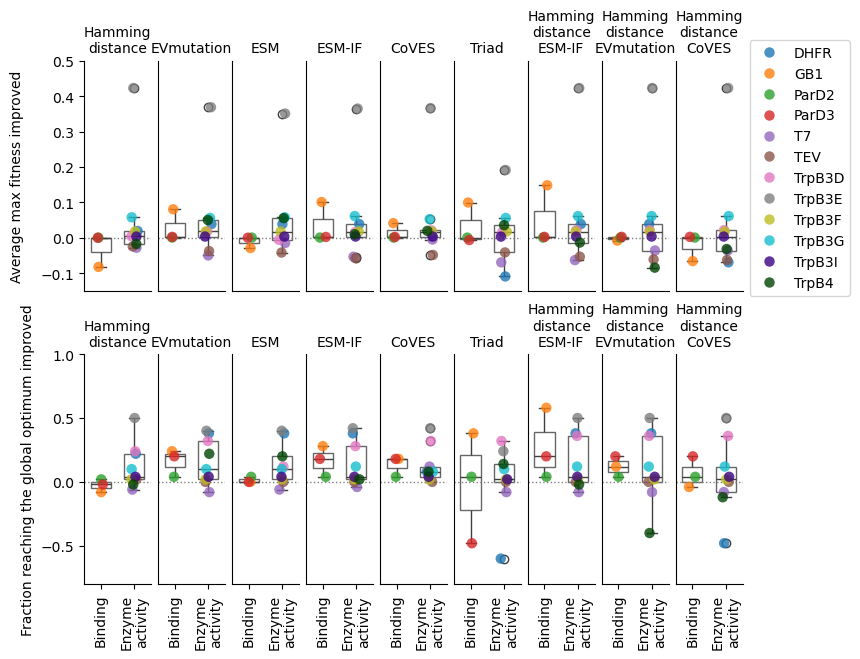

In [18]:
n_round = 4
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

ed : t=0.085 and p=0.937
ev : t=0.810 and p=0.438
esm : t=0.275 and p=0.794
esmif : t=0.851 and p=0.415
coves : t=0.495 and p=0.636
Triad : t=1.254 and p=0.242
ds-esmif : t=1.183 and p=0.265
ds-ev : t=0.483 and p=0.645
ds-coves : t=0.213 and p=0.841
ed : t=-0.397 and p=0.716
ev : t=0.453 and p=0.674
esm : t=-0.118 and p=0.913
esmif : t=0.376 and p=0.725
coves : t=0.405 and p=0.709
Triad : t=-0.062 and p=0.954
ds-esmif : t=0.650 and p=0.539
ds-ev : t=0.277 and p=0.795
ds-coves : t=0.380 and p=0.727


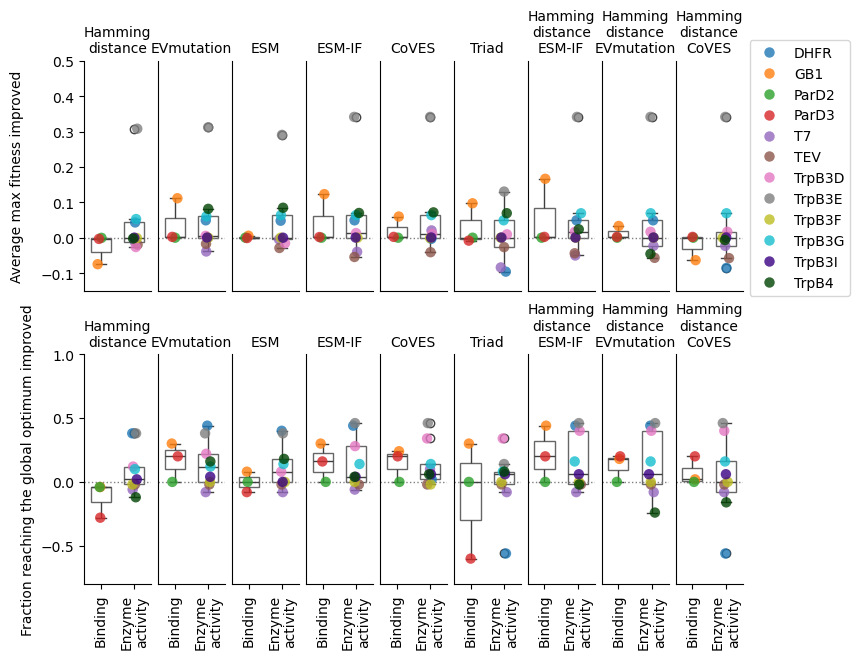

In [20]:
n_round = 3
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

ed : t=0.047 and p=0.965
ev : t=0.773 and p=0.462
esm : t=0.232 and p=0.827
esmif : t=0.771 and p=0.463
coves : t=0.368 and p=0.727
Triad : t=1.610 and p=0.139
ds-esmif : t=0.582 and p=0.577
ds-ev : t=0.323 and p=0.759
ds-coves : t=0.128 and p=0.905
ed : t=-0.441 and p=0.688
ev : t=0.414 and p=0.704
esm : t=-0.263 and p=0.809
esmif : t=0.296 and p=0.782
coves : t=0.327 and p=0.766
Triad : t=0.120 and p=0.911
ds-esmif : t=-0.024 and p=0.982
ds-ev : t=0.157 and p=0.884
ds-coves : t=0.289 and p=0.790


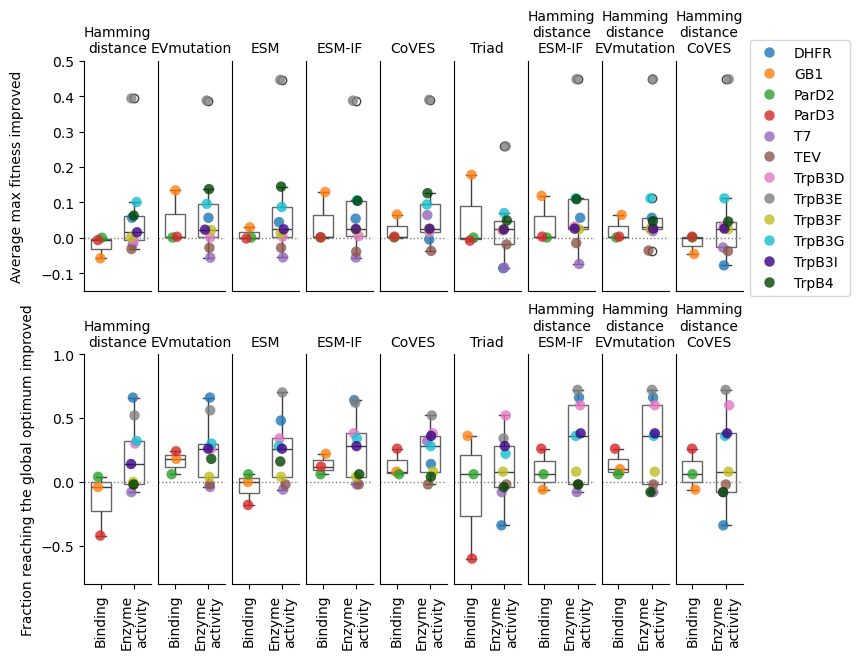

In [21]:
n_round = 2
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

ed : t=0.295 and p=0.786
ev : t=0.655 and p=0.544
esm : t=0.379 and p=0.729
esmif : t=0.847 and p=0.431
coves : t=0.640 and p=0.557
Triad : t=1.012 and p=0.359
ds-esmif : t=0.295 and p=0.780
ds-ev : t=0.370 and p=0.727
ds-coves : t=0.170 and p=0.874
ed : t=-0.203 and p=0.852
ev : t=0.431 and p=0.696
esm : t=0.120 and p=0.913
esmif : t=0.716 and p=0.522
coves : t=0.312 and p=0.776
Triad : t=-0.050 and p=0.963
ds-esmif : t=0.223 and p=0.836
ds-ev : t=0.417 and p=0.699
ds-coves : t=0.082 and p=0.940


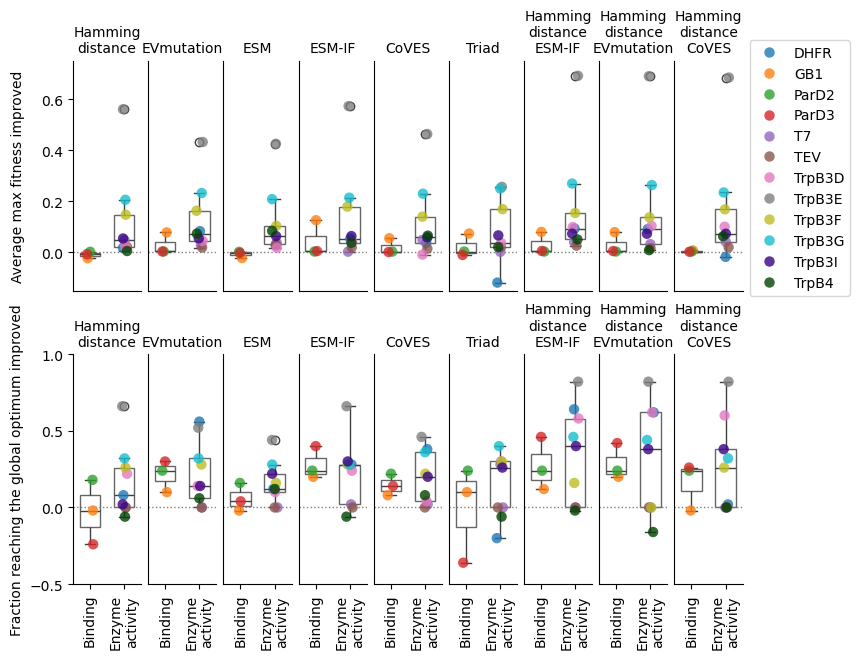

In [29]:
n_round = 4
n_sample = int((96 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.75
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.5, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

ed : t=0.529 and p=0.637
ev : t=0.901 and p=0.426
esm : t=0.746 and p=0.512
esmif : t=0.687 and p=0.537
coves : t=0.579 and p=0.604
Triad : t=1.264 and p=0.278
ds-esmif : t=0.101 and p=0.925
ds-ev : t=0.149 and p=0.889
ds-coves : t=0.165 and p=0.878
ed : t=0.371 and p=0.742
ev : t=0.737 and p=0.522
esm : t=0.537 and p=0.639
esmif : t=0.542 and p=0.631
coves : t=0.852 and p=0.471
Triad : t=0.338 and p=0.761
ds-esmif : t=0.179 and p=0.870
ds-ev : t=0.342 and p=0.756
ds-coves : t=0.409 and p=0.710


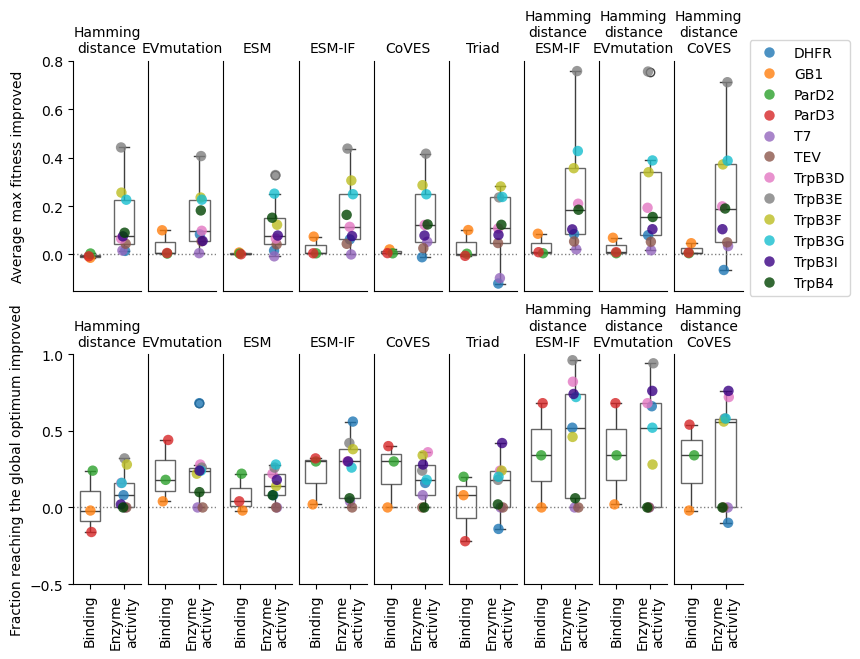

In [28]:
n_round = 2
n_sample = int((96 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.8
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.5, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)